## Importing

In [68]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np

# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
#from run_sem_with_features import preprocess_skel
import joblib
from utils import get_point_biserial, get_binned_prediction
from utils import contain_substr
import seaborn as sns

pn.extension()


In [69]:
# %matplotlib inline
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 12), sharex='all')
# cbar_ax = fig.add_axes([.125, .2, .775, .03])
# pos1 = ax1.get_position()
# pos1
# pos2 = ax2.get_position()
# pos2
# pos3 = ax3.get_position()
# pos3
# pos_cbar = cbar_ax.get_position()
# pos_cbar
# sem_readouts = pkl.load(open(f'output/run_sem/{default_tag}/{default_run}_kinect_trim{default_tag}_diagnostic{epoch}.pkl', 'rb'))
# inputdf = pkl.load(open(f'output/run_sem/{default_tag}/{default_run}_kinect_trim{default_tag}_inputdf{epoch}.pkl', 'rb'))
# df_lik = pd.DataFrame(sem_readouts['log_like'], index=inputdf.appear_post.index)
# pd.set_option('use_inf_as_na', True)
# df_filtered_lik = df_lik.dropna(axis=1, how='all')
# sns.heatmap(df_filtered_lik.T, ax=ax2,
#             cbar_kws={"orientation": "horizontal"},
#             # vmin=min_color, vmax=max_color,
#             cbar_ax=cbar_ax,
#             )

### Initialize Variables and Widgets

In [70]:

default_run='3.4.9'
default_tag='may_11_no_skel2D_individual'
epoch= '_3'
available_runs = glob(f'output/run_sem/{default_tag}/*inputdf*.pkl')
available_runs = list(set([os.path.basename(r).split('_')[0] for r in available_runs]))
print(available_runs)
available_tags = ['may_03_no_skel2D_selection', 'may_03_use_skel2D_selection', 'may_03_no_skel2d_no_selection']
print(available_tags)

run_select = pn.widgets.Select(name='Select Run', options=available_runs, value=f'{default_run}')
tag_select = pn.widgets.Select(name='Select tag', options=available_tags, value=f'{default_tag}')
multi_run_select = pn.widgets.MultiSelect(name='Select 2 or 3 Runs for Comparison', value=[default_run], options=available_runs)
multi_tag_select = pn.widgets.MultiSelect(name='Select 2 or 3 Tags for Comparison', value=[default_tag], options=available_tags)
inverted_checkbox = pn.widgets.Checkbox(name='Show Inverted Features?', value=False)
account_influence = pn.widgets.Checkbox(name='Account for # of Features on Vector?', value=True)


['3.4.9']
['may_03_no_skel2D_selection', 'may_03_use_skel2D_selection', 'may_03_no_skel2d_no_selection']


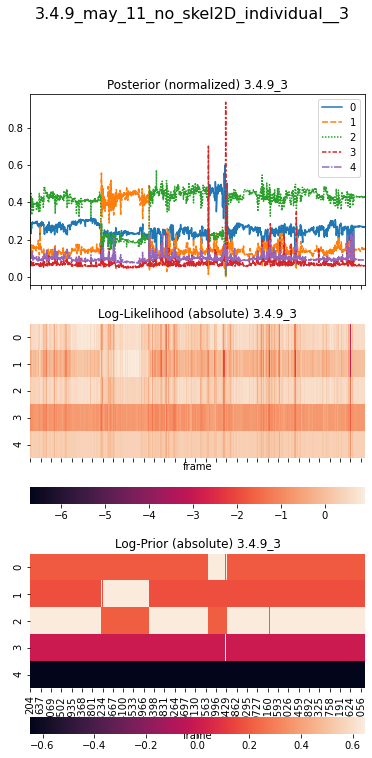

In [72]:
%matplotlib inline
pd.set_option('use_inf_as_na', True)
sem_readouts = pkl.load(open(f'output/run_sem/{default_tag}/{default_run}_kinect_trim{default_tag}_diagnostic{epoch}.pkl', 'rb'))
inputdf = pkl.load(open(f'output/run_sem/{default_tag}/{default_run}_kinect_trim{default_tag}_inputdf{epoch}.pkl', 'rb'))
# somehow sns.heatmap treat index as counting from 0
# while sns.lineplot (or df.plot.are) count from index of dataframe
# if want to sharex, have to index posterior (lineplot) from 0
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 12), sharex='all')
df_post = pd.DataFrame(sem_readouts['post'])
df_filtered_post = df_post.loc[:, (df_post != 0).any(axis=0)]
sns.lineplot(data=df_filtered_post, ax=ax1)
ax1.set_title(f'Posterior (normalized) {default_run}{epoch}')

# cbar_ax = fig.add_axes([.91, .3, .03, .4])
# fig.tight_layout()
# cbar_ax = fig.add_axes([.125, .0, .775, .03])
df_lik = pd.DataFrame(sem_readouts['log_like'], index=inputdf.appear_post.index)
df_filtered_lik = df_lik.dropna(axis=1, how='all')
df_prior = pd.DataFrame(sem_readouts['log_prior'], index=inputdf.appear_post.index)
df_filtered_prior = df_prior.dropna(axis=1, how='all')
max_color = max(df_filtered_lik.max().max(), df_filtered_prior.max().max())
min_color = min(df_filtered_lik.min().min(), df_filtered_prior.min().min())
sns.heatmap(df_filtered_lik.T, ax=ax2,
            cbar_kws={"orientation": "horizontal"},
            # vmin=min_color, vmax=max_color,
            # cbar_ax=cbar_ax,
            )
ax2.set_title(f'Log-Likelihood (absolute) {default_run}{epoch}')
sns.heatmap(df_filtered_prior.T, ax=ax3,
            cbar_kws={"orientation": "horizontal"},
            # vmin=min_color, vmax=max_color,
            # cbar_ax=cbar_ax,
            )
ax3.set_title(f'Log-Prior (absolute) {default_run}{epoch}')
fig.suptitle(f'{default_run}_{default_tag}_{epoch}', fontsize=16)
plt.savefig(f'{default_run}_probabilities.png')

Bbox([[0.125, 0.0], [0.9, 0.03]])

In [35]:
import seaborn as sns

@pn.depends(run_select.param.value, tag_select.param.value, inverted_checkbox.param.value)
def plot_heatmap_prediction(run_select, tag_select, inverted_checkbox, fig=None, axes=None, cbar_ax=None, min_heat=-4, max_heat=4):
    if fig is None:
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex=True)
        cbar_ax = fig.add_axes([.91, .3, .03, .4])
    run = int(run_select.split('.')[-1].split('_')[0])
    if run <= 8:
        # Train videos
        epochs = ['_' + str(run)]
    else:
        # Valid videos
        epochs = ['_1', '_2', '_4']

    for index, epoch in enumerate(epochs):

        inputdf = pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_inputdf{epoch}.pkl', 'rb'))

        appear_df_post = inputdf.appear_post
        optical_df_post = inputdf.optical_post
        skel_df_post = inputdf.skel_post
        objhand_df_post = inputdf.objhand_post

        input_pca = inputdf.x_train_pca
        pred_pca = inputdf.x_inferred_pca
        if inverted_checkbox:
            input_inverted = inputdf.x_train_inverted
            pred_inverted = inputdf.x_inferred_inverted
            # to remove 3D and 2D columns if necessary
            remove = ['3D', '2D']
            for c in input_inverted.columns:
                if contain_substr(c, keeps=remove):
                    pred_inverted.drop([c], axis=1, inplace=True)
                    input_inverted.drop([c], axis=1, inplace=True)
            input = input_inverted
            pred = pred_inverted
        else:
            input = input_pca
            pred = pred_pca

        for i, ax in enumerate(axes[:, index].flat):
            sns.heatmap(pred.iloc[:200, :].T if i else input.iloc[:200, :].T, ax=ax,
                        cbar=i == 0,
                        vmin=min_heat, vmax=max_heat,
                        cbar_ax=None if i else cbar_ax)
            ax.set_title(f'{run_select} ' + (f'Prediction {tag_select}' if i else 'Input'))

#     fig.savefig(f'{run_select}_{tag_select}_heatmap.png')
    return fig

@pn.depends(multi_tag_select.param.value, run_select.param.value, inverted_checkbox.param.value)
def multi_tags_across_epochs(multi_tag_select, run_select, inverted_checkbox):
    if len(multi_tag_select) > 1:
        fig, axes = plt.subplots(nrows=len(multi_tag_select) * 2, ncols=3, figsize=(15, 5.5*len(multi_tag_select)), sharex='all')
        cbar_ax = fig.add_axes([.91, .3, .03, .4])
        for i, tag in enumerate(multi_tag_select):
            fig = plot_heatmap_prediction(run_select=run_select, tag_select=tag,
                                          inverted_checkbox=inverted_checkbox,
                                          fig=fig, axes=axes[i*2:(i+1)*2, :], cbar_ax=cbar_ax)

    else:
        fig = plot_heatmap_prediction(run_select=run_select, tag_select=multi_tag_select[0],
                                      inverted_checkbox=inverted_checkbox)
    fig.savefig(f'{run_select}_heatmap_across_tags.png')
    return fig
# sns.heatmap(pred_pca.iloc[:100, :].T, ax=axes[0])
# sns.heatmap(input_pca.iloc[:100, :].T, ax=axes[1])

### Compare PE across epochs

Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] Select(options=['3.4.9', '3.4.2', ...], value='3.4.9')
        [1] MultiSelect(name='Select 2 or 3..., options=['may_03_no_skel2D_selecti...], value=['may_03_no_skel2D_selecti...])
        [2] Checkbox(name='Show Inverted Features?')
    [2] ParamFunction(function)
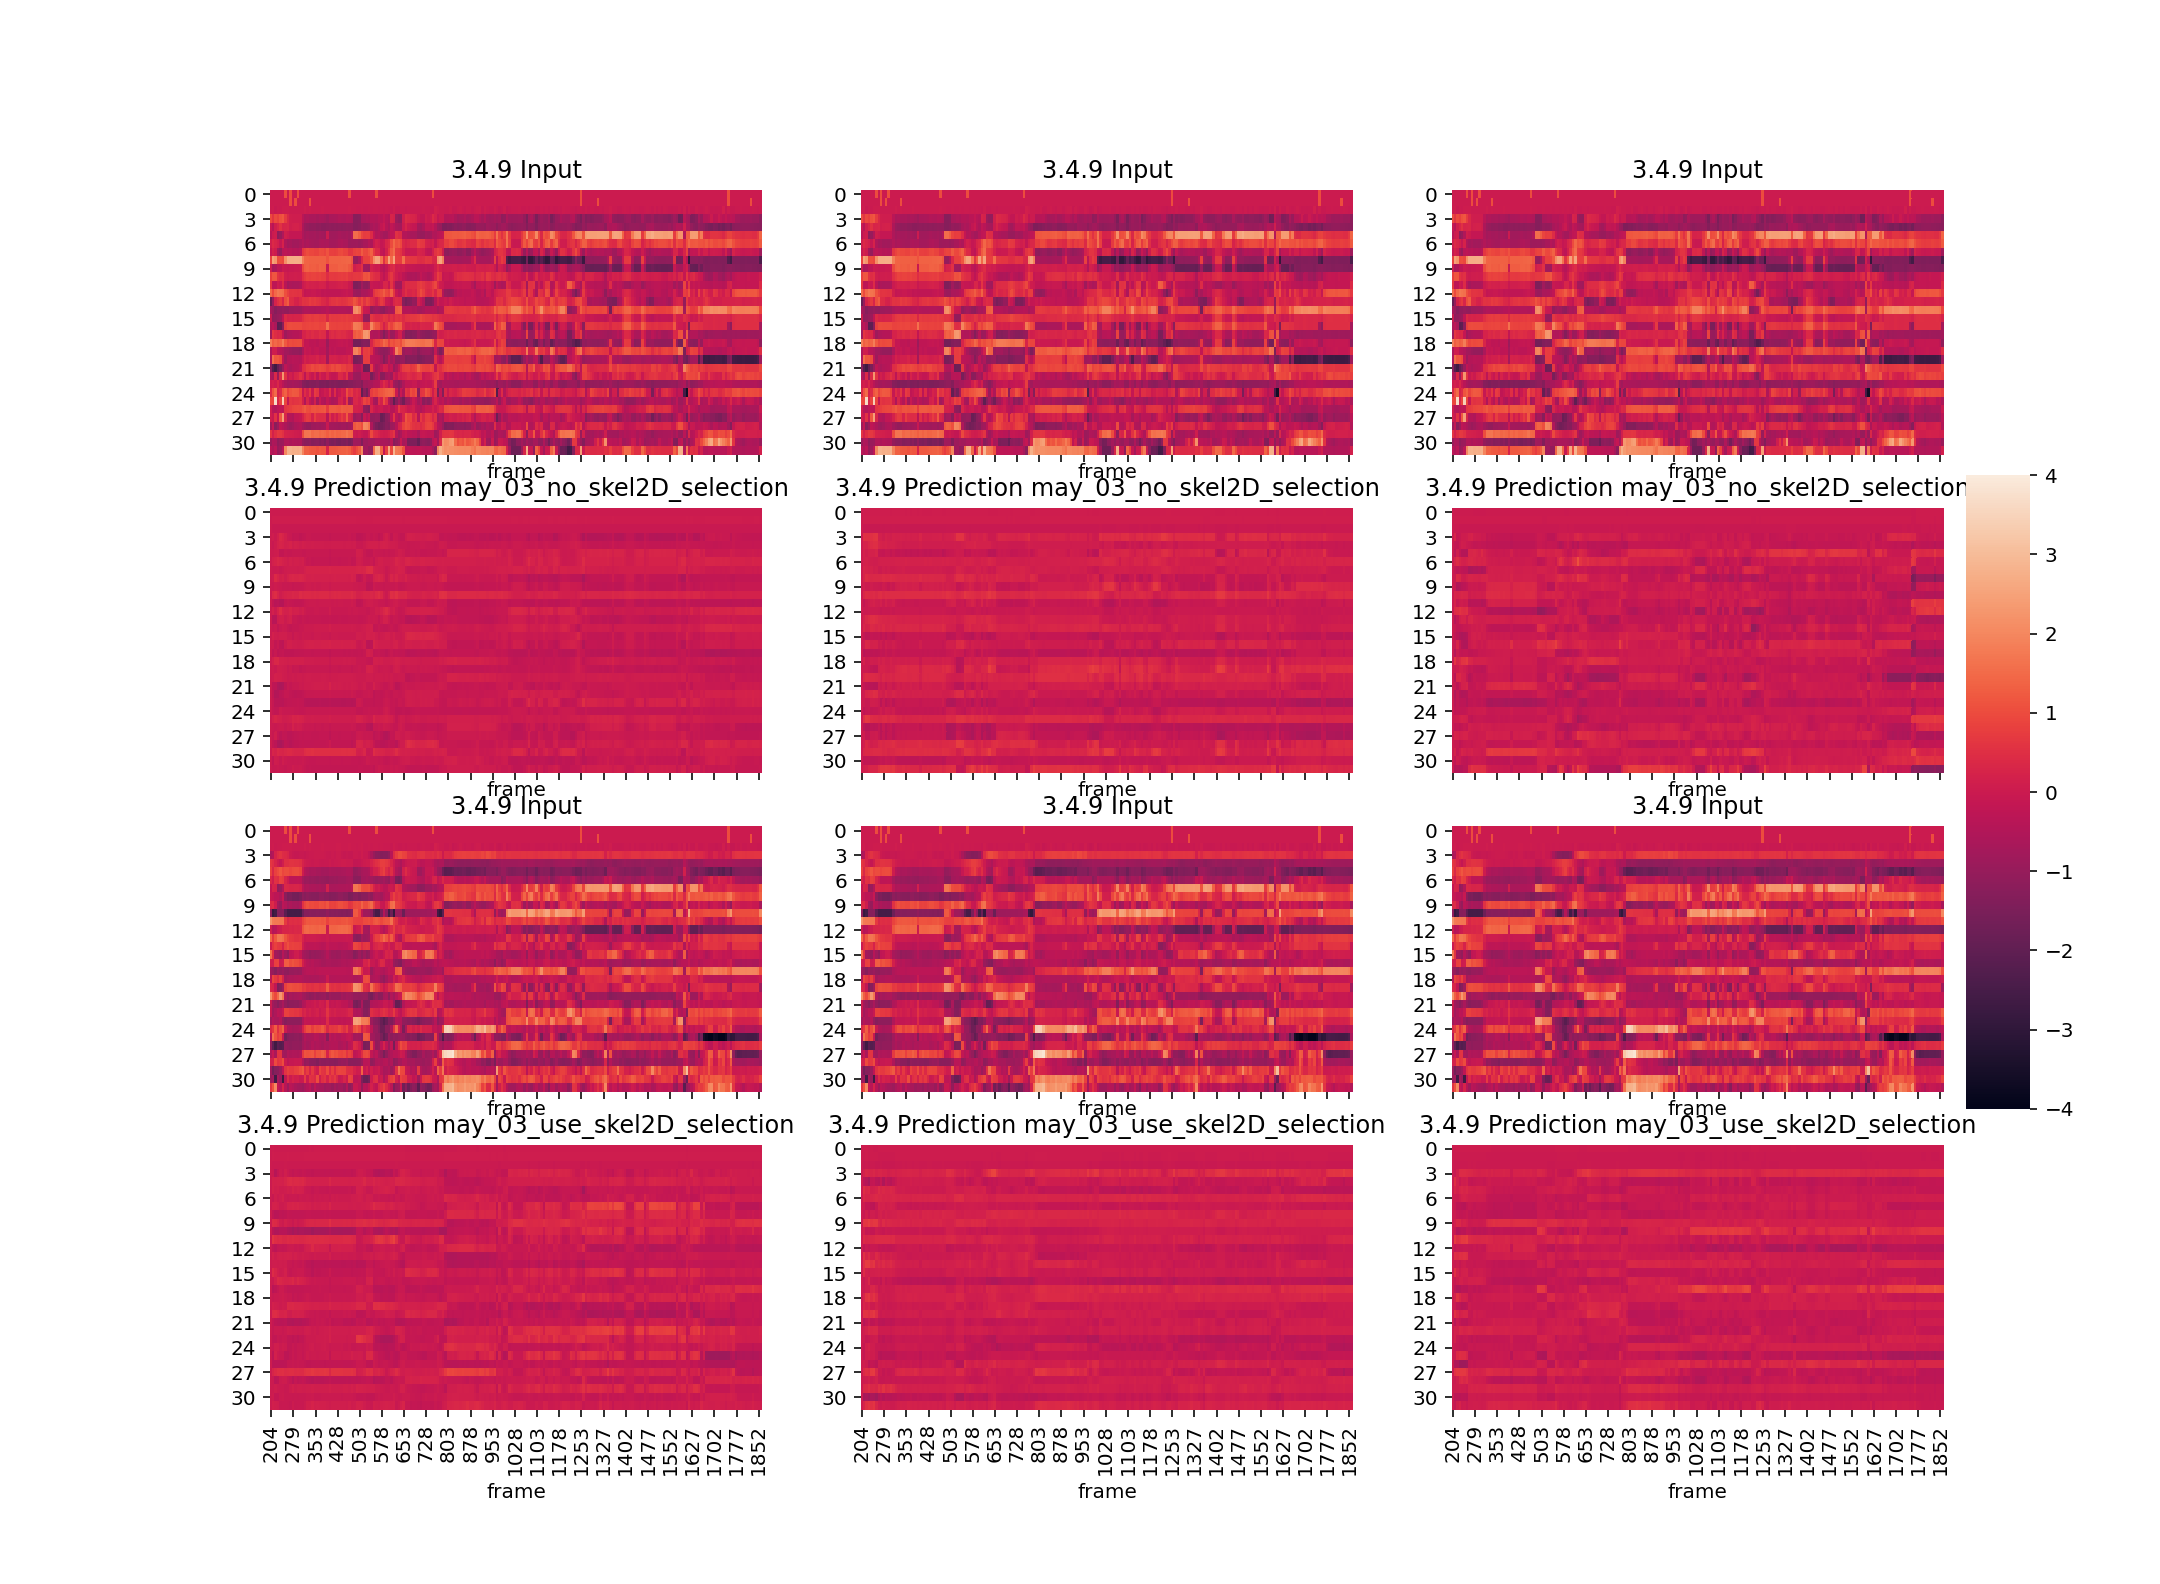

In [36]:
dashboard = pn.Column(
    pn.Row('Compare Heatmap of Prediction across Epochs'),
    pn.Row(run_select, multi_tag_select, inverted_checkbox),
    multi_tags_across_epochs
)

# Launch the dashboard
dashboard.servable()

<AxesSubplot:xlabel='frame'>

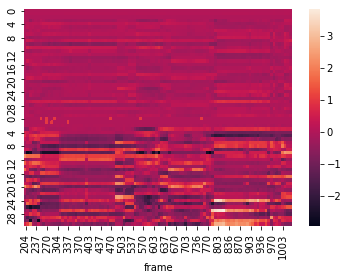

In [4]:
# sns.heatmap(pd.concat([pred_pca.iloc[:100, :], input_pca.iloc[:100, :]], axis=1).T)
tag = 'may_03_use_skel2D_selection'
inputdf = pkl.load(open(f'output/run_sem/{tag}/{default_run}_kinect_trim{tag}_inputdf{epoch}.pkl', 'rb'))


input_inverted = inputdf.x_train_inverted
input_pca = inputdf.x_train_pca
pred_pca = inputdf.x_inferred_pca
pred_inverted = inputdf.x_inferred_inverted

%matplotlib inline
fig, ax = plt.subplots()
sns.heatmap(pd.concat([pred_pca.iloc[:100, :], input_pca.iloc[:100, :]], axis=1).T, ax=ax)
